# Setting

In [1]:
from gurobipy import *
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr


# KB Finance(105560), Hyundai Mtr(005380), SK Hynix(000660)

'''
한국거래소 시가총액 상위 20개 중 10개 종목
005930	삼성전자
000660	SK하이닉스
035420	NAVER
005380	현대차
068270	셀트리온
051910	LG화학
055550  신한지주
005490  POSCO
017670  SK텔레콤
051900  LG생활건강

'''

ticker_list = ['005930', '000660', '035420', '005380', '068270', '051910', '055550', '005490', '017670', '051900']
df_list = [fdr.DataReader(ticker, '2015-01-01', '2017-12-31')['Change'] for ticker in ticker_list]

df = pd.concat(df_list, axis=1)
#df.columns = ['005930', '000660', '005935', '035420', '005380', '207940', '012330', '068270', '051910', '055550', '069500']
df.columns = ['삼성전자', 'SK하이닉스', 'NAVER', '현대차',
              '셀트리온','LG화학', '신한지주', 'POSCO', 'SK텔레콤', 'LG생활건강']

r = df.dropna()
rf = 0.0125  # 기준 금리


#df = df.resample('Y').agg(lambda x:x.mean()*252)


# Calculate basic summary statistics for individual stocks
stock_volatility = r.std() * np.sqrt(252)
stock_return = r.mean() * 252
cov = r.cov() * 252

# Calculate basic summary statistics for individual stocks

stock_volatility = r.std() * np.sqrt(252)
stock_return = r.mean() * 252

## Minimum risk Portfolio

In [2]:
# Create an empty model
m = Model('portfolio')

# Add a variable for each stock
vars = pd.Series(m.addVars(df.columns), index=df.columns) # weight

# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between stocks.

#sigma = data.cov()
portfolio_risk = cov.dot(vars).dot(vars) # Quadratic Programming
m.setObjective(portfolio_risk, GRB.MINIMIZE)

# Fix budget with a constraint
m.addConstr(vars.sum() == 1, 'budget')

# Optimize model to find the minimum risk portfolio
m.setParam('OutputFlag', 0)
m.optimize()

# Create an expression representing the expected return for the portfolio
portfolio_return = stock_return.dot(vars)

# Display minimum risk portfolio
print('Minimum Risk Portfolio:\n')

X = []
for v in vars:
    X.append(v.x)

for i in range(len(vars.index)):
#     print(vars.index[i]+ " : ", X[i])
#     name = vars.index[i]
#     value = X[i]
#     print('\t%s\t: %g' % (name, value))
    print('%s\t\t: %g' % (vars.index[i], X[i]))


minrisk_volatility = sqrt(portfolio_risk.getValue())
print('\nVolatility      = %g' % minrisk_volatility)
minrisk_return = portfolio_return.getValue()
print('Expected Return = %g' % minrisk_return)

Academic license - for non-commercial use only
Minimum Risk Portfolio:

삼성전자		: 0.16924
SK하이닉스		: 0.0283659
NAVER		: 0.0721975
현대차		: 0.118023
셀트리온		: 0.0422713
LG화학		: 0.0503869
신한지주		: 0.13129
POSCO		: 0.0464872
SK텔레콤		: 0.243841
LG생활건강		: 0.0978973

Volatility      = 0.128164
Expected Return = 0.15695


In [3]:
sharpe = (stock_return - rf) / stock_volatility
ind = ['Expected Return', 'Volatility', 'Sharpe Ratio' ]
temp = pd.DataFrame([stock_return, stock_volatility, sharpe], index=ind).transpose()
temp

,Expected Return,Volatility,Sharpe Ratio
삼성전자,0.256378,0.257771,0.946104
SK하이닉스,0.221552,0.347812,0.601048
NAVER,0.121247,0.324492,0.335130
현대차,0.013051,0.284847,0.001935
셀트리온,0.738114,0.475787,1.525081
LG화학,0.337601,0.353303,0.920175
신한지주,0.066093,0.245276,0.218499
POSCO,0.114905,0.319017,0.321001
SK텔레콤,0.026939,0.237919,0.060687
LG생활건강,0.287876,0.366403,0.751565


## Optimal PF, [Merton 1971](https://www.sciencedirect.com/science/article/pii/002205317190038X)

In [4]:
cov_inv = np.linalg.inv(cov)
temp = np.dot(cov_inv, (stock_return- rf))
theta_opt = temp / temp.sum() # optimal weight in Risky Mutual fund

In [5]:
alpha = np.dot(theta_opt, stock_return)
print(alpha)

0.4321381092802477


In [6]:
cov_inv = np.linalg.inv(cov)
temp = np.dot(cov_inv, (stock_return- rf))
theta_opt = temp / temp.sum() # optimal weight in Risky Mutual fund

alpha = np.dot(theta_opt, stock_return) # 0.5941
sigma = np.sqrt(cov.dot(theta_opt).dot(theta_opt))
print(alpha, sigma)

0.4321381092802477 0.21844679528037375


## Plotting

In [9]:
# Solve for efficient frontier by varying target return
target = m.addConstr(portfolio_return == minrisk_return, 'target')
frontier = pd.Series()
for r_ in np.linspace(stock_return.min(), stock_return.max(), 100):
    target.rhs = r_
    m.optimize() # return이 주어질 때 최적 weight에 대해서 optimize
    frontier.loc[sqrt(portfolio_risk.getValue())] = r_

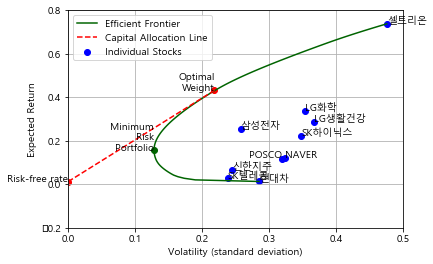

In [14]:
CAL = (alpha-rf)/sigma * np.linspace(0, sigma, 100) + rf

#%%
# Plot volatility versus expected return for individual stocks
plt.rc('font', family='Malgun Gothic')
ax = plt.gca()
ax.scatter(x=stock_volatility, y=stock_return,
           color='Blue', label='Individual Stocks')


for i, stock in enumerate(df.columns):
    if i != 7:
        ax.annotate(stock, (stock_volatility[i], stock_return[i]))
    else:
        ax.annotate(stock, (stock_volatility[i], stock_return[i]), 
                    horizontalalignment='right',
                    verticalalignment='bottom')
        
# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')
ax.scatter(x=sigma, y=alpha, color='Red')
ax.annotate('Optimal\nWeight', (sigma, alpha),
            horizontalalignment='right')
#
ax.scatter(x=0, y=rf, color='Red')
ax.annotate('Risk-free rate', (0, rf),
           horizontalalignment='right')



# Plot efficient frontier
frontier.plot(color='DarkGreen', label='Efficient Frontier', ax=ax)
plt.plot(np.linspace(0, sigma, 100),CAL, '--', color='r', label='Capital Allocation Line')
# Format and display the final plot
ax.axis([0.0, 0.5, -0.2, 0.8])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()